In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Industrials 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable
1159,1997-12-02,971.68,210.110001,-10.453318,-5.932127,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1160,1997-12-03,976.77,209.130005,-10.766293,-7.542330,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1161,1997-12-04,973.10,208.500000,-12.471329,-9.638556,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1162,1997-12-05,983.79,210.610001,-12.239964,-9.011967,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1163,1997-12-08,982.37,210.490005,-12.450204,-9.114853,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,895.200012,5.426902,3.840664,UNDERPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416
7195,2021-11-26,4594.62,870.760010,4.573863,2.027041,UNDERPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416
7196,2021-11-29,4655.27,872.809998,8.977288,4.874797,UNDERPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416
7197,2021-11-30,4567.00,850.539978,6.305224,2.197654,UNDERPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416


## Using data after 2010

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable,dow
145,2010,1,2010-01-14,1148.46,257.549988,8.787618,6.166780,UNDERPERFORM,217.281,209.624,174.321,84.849,191.978,259.970,111.811,3
146,2010,2,2010-02-11,1078.47,242.679993,1.716544,-0.197405,UNDERPERFORM,217.353,209.326,174.137,84.868,191.375,260.342,111.683,3
147,2010,3,2010-03-11,1150.24,262.059998,2.657837,-1.791335,UNDERPERFORM,217.403,209.219,173.874,84.840,191.249,260.672,111.397,3
148,2010,4,2010-04-08,1186.44,276.230011,13.110628,13.074632,UNDERPERFORM,217.290,206.631,173.367,84.738,190.231,260.932,111.206,3
149,2010,5,2010-05-13,1157.44,277.670013,-0.285160,0.791326,OUTPERFORM,217.199,203.764,172.929,84.622,189.426,261.188,110.989,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2021,7,2021-07-08,4320.82,861.239990,-7.184331,-1.325604,OUTPERFORM,273.092,242.958,201.975,76.056,236.783,342.831,120.078,3
284,2021,8,2021-08-12,4460.83,889.830017,-6.940799,-1.744641,OUTPERFORM,274.214,245.847,203.215,76.337,237.107,343.808,120.714,3
285,2021,9,2021-09-09,4493.28,863.659973,-1.171440,-0.089078,OUTPERFORM,276.590,255.010,206.035,76.407,241.826,345.648,122.650,3
286,2021,10,2021-10-14,4438.26,861.609985,3.749053,3.353921,UNDERPERFORM,278.524,261.257,208.467,76.317,246.749,346.911,124.413,3


In [4]:
original = data[['S&P 500 Industrials (Sector) Outperform/Underperform','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]

In [5]:
data.drop(columns=['date','S&P 500 Industrials (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
145,1,1148.46,257.549988,8.787618,6.166780,217.281,209.624,174.321,84.849,191.978,259.970,111.811,3
146,2,1078.47,242.679993,1.716544,-0.197405,217.353,209.326,174.137,84.868,191.375,260.342,111.683,3
147,3,1150.24,262.059998,2.657837,-1.791335,217.403,209.219,173.874,84.840,191.249,260.672,111.397,3
148,4,1186.44,276.230011,13.110628,13.074632,217.290,206.631,173.367,84.738,190.231,260.932,111.206,3
149,5,1157.44,277.670013,-0.285160,0.791326,217.199,203.764,172.929,84.622,189.426,261.188,110.989,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Industrials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,9
Size in Memory,11.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.55,0.50,2,78
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
energy,float64,0,0,176.40,218.54,263.55,221.44,21.49,143,1
commodities,float64,0,0,172.93,184.92,210.45,184.87,6.15,143,1
communication,float64,0,0,72.92,79.91,84.87,78.92,4.086,141,2
transportation,float64,0,0,188.78,209.96,250.10,208.81,11.62,143,1
services,float64,0,0,259.97,295.76,348.10,298.29,25.70,143,1
durable,float64,0,0,103.43,109.32,126.42,109.35,4.25,142,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

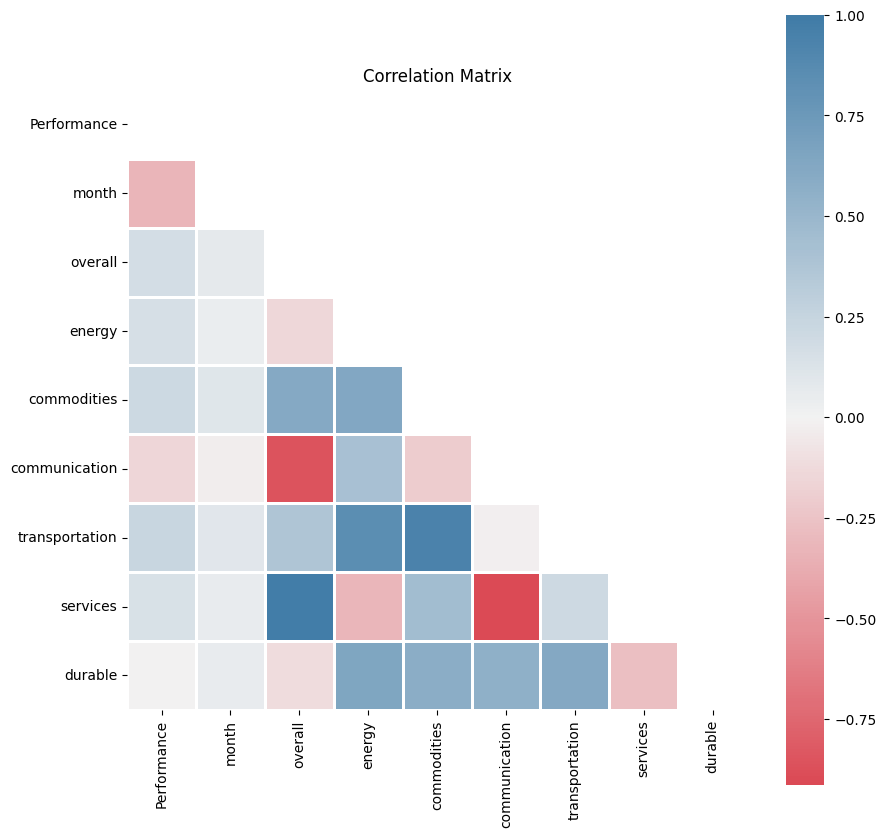

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
0,7,1344.738031,316.276828,-7.244538,-8.431653,233.655535,244.379145,185.227836,83.284997,212.111582,276.230178,110.997558,3
1,10,3512.849410,794.263427,-4.858036,-6.942525,267.660055,230.703910,186.805183,73.239867,212.677659,344.833797,102.907219,3
2,4,4501.524235,586.809675,-11.674766,-11.449443,250.061127,207.558768,185.480291,73.072719,211.140528,327.125101,106.264251,3
3,11,2179.097967,381.018346,-4.150219,-6.092809,246.786818,248.410476,205.457266,83.744392,222.188596,286.325634,112.574038,3
4,11,1385.747507,344.705363,-2.965612,3.575958,223.734141,250.510387,182.950959,81.471111,212.317004,275.058414,110.854101,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9,3509.840931,752.540779,-2.034111,18.573719,257.383729,217.947534,186.045695,72.635322,212.306623,337.441670,103.949376,3
9996,3,2247.016218,520.954814,-7.076046,2.051704,250.126452,209.049482,183.214873,80.142408,205.990122,276.618990,105.463448,3
9997,11,2657.926804,518.244354,-13.864526,-17.381940,240.480305,189.958529,181.701702,73.540635,208.641286,317.833731,105.869190,3
9998,5,3473.828463,712.255418,-4.123010,9.880754,263.544901,204.606078,185.161087,73.055393,209.303062,343.226192,103.794856,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Industrials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
samples.head()

,Performance,month,overall,energy,commodities,communication,transportation,services,durable
0,0,7,233.655535,244.379145,185.227836,83.284997,212.111582,276.230178,110.997558
1,0,10,267.660055,230.703910,186.805183,73.239867,212.677659,344.833797,102.907219
2,1,4,250.061127,207.558768,185.480291,73.072719,211.140528,327.125101,106.264251
3,0,11,246.786818,248.410476,205.457266,83.744392,222.188596,286.325634,112.574038
4,1,11,223.734141,250.510387,182.950959,81.471111,212.317004,275.058414,110.854101


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,9
Size in Memory,703.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.57,0.49,2,5719
month,int64,0,0,1,7,12,6.54,3.42,12,891
overall,float64,0,0,211.61,237.88,293.72,242.19,15.49,10000,1
energy,float64,0,0,172.084,218.87,265.60,224.30,19.84,9999,2
commodities,float64,0,0,170.026,184.45,213.35,184.28,6.40,10000,1
communication,float64,0,0,70.40,81.098,87.52,79.15,4.44,10000,1
transportation,float64,0,0,185.83,211.45,266.26,209.94,12.096,9999,2
services,float64,0,0,242.39,289.59,372.43,299.66,28.55,10000,1
durable,float64,0,0,101.87,109.95,134.073,109.25,4.39,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

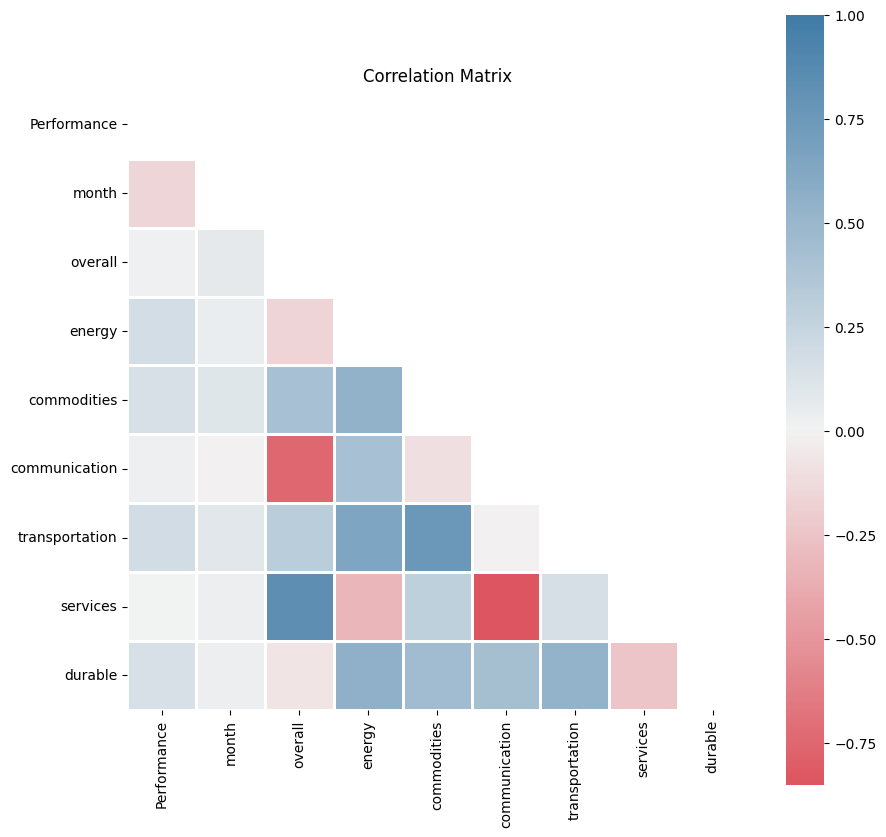

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 5719, 0: 4281})
Counter({0: 5719, 1: 5719})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  233.65553536,   244.379145  ,   185.22783552, ...,
        58591.62010046, 23543.86760298, 30660.87511994],
       [  267.66005491,   230.70390953,   186.80518333, ...,
        73338.44457112, 21886.06642767, 35485.88702419],
       [  250.06112743,   207.55876828,   185.48029109, ...,
        69069.36644637, 22436.69006769, 34761.70393099],
       ...,
       [  267.61238681,   254.19643822,   200.63125663, ...,
        74187.91881065, 25175.62860871, 39076.74046069],
       [  268.19116978,   202.8838858 ,   185.85429839, ...,
        67739.43467125, 21331.38981531, 35168.44759609],
       [  229.31414299,   200.48142064,   179.7926958 , ...,
        55147.92204812, 21531.30342851, 30827.92988501]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(11438, 29)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 29)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.656856,0.679834,0.605524,0.639051,0.650699,0.673692,0.597645,0.633394,0.573427,0.61039,0.602564,0.606452
1,DecisionTreeClassifier,0.637885,0.646737,0.620739,0.632018,0.622378,0.627451,0.620499,0.623955,0.545455,0.580247,0.602564,0.591195
2,RandomForestClassifier,0.715523,0.735703,0.689803,0.709291,0.71049,0.719686,0.698753,0.709065,0.657343,0.704225,0.641026,0.671141
3,AdaBoostClassifier,0.676607,0.683199,0.660078,0.671161,0.682168,0.698589,0.651662,0.67431,0.643357,0.690141,0.628205,0.657718
4,GradientBoostingClassifier,0.685001,0.690323,0.672142,0.680822,0.698951,0.716407,0.668283,0.691508,0.685315,0.73913,0.653846,0.693878
5,ExtraTreesClassifier,0.727591,0.753836,0.700819,0.722231,0.716783,0.734467,0.687673,0.7103,0.664336,0.682927,0.717949,0.7
6,BaggingClassifier,0.684046,0.72682,0.599403,0.655652,0.674825,0.710656,0.600416,0.650901,0.615385,0.694915,0.525641,0.59854
7,SVC,0.657023,0.680624,0.593634,0.633907,0.65,0.682305,0.5741,0.623543,0.636364,0.69697,0.589744,0.638889
8,GaussianNB,0.573788,0.610639,0.408986,0.489646,0.582168,0.629016,0.42036,0.503944,0.531469,0.612245,0.384615,0.472441


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.711189,0.725547,0.688366,0.706468


## Using data after 2000 (Best Model)

In [22]:
data = pd.read_csv('../data/S&P 500 Industrials 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable,dow
25,2000,1,2000-01-13,1449.68,271.299988,-1.473467,0.288333,OUTPERFORM,170.000,118.800,147.600,94.700,150.000,192.500,125.100,3
26,2000,2,2000-02-10,1416.83,242.419998,-2.032872,-7.168575,UNDERPERFORM,171.000,124.300,149.100,94.200,153.600,193.100,125.500,3
27,2000,3,2000-03-09,1401.69,237.440002,-2.531813,-12.741165,UNDERPERFORM,170.900,120.900,148.500,93.800,152.100,193.500,125.400,3
28,2000,4,2000-04-13,1440.51,265.179993,-3.467247,-10.357654,UNDERPERFORM,171.200,120.000,148.500,93.700,152.000,194.000,125.800,3
29,2000,5,2000-05-11,1407.81,269.410004,-1.307432,-7.562191,UNDERPERFORM,172.200,126.800,149.600,92.600,155.000,194.900,125.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2021,7,2021-07-08,4320.82,861.239990,-7.184331,-1.325604,OUTPERFORM,273.092,242.958,201.975,76.056,236.783,342.831,120.078,3
284,2021,8,2021-08-12,4460.83,889.830017,-6.940799,-1.744641,OUTPERFORM,274.214,245.847,203.215,76.337,237.107,343.808,120.714,3
285,2021,9,2021-09-09,4493.28,863.659973,-1.171440,-0.089078,OUTPERFORM,276.590,255.010,206.035,76.407,241.826,345.648,122.650,3
286,2021,10,2021-10-14,4438.26,861.609985,3.749053,3.353921,UNDERPERFORM,278.524,261.257,208.467,76.317,246.749,346.911,124.413,3


In [23]:
original = data[['S&P 500 Industrials (Sector) Outperform/Underperform','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
data.drop(columns=['date','S&P 500 Industrials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Industrials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
0,1,1767.571142,552.940089,4.262186,-1.143829,219.461692,145.222653,154.110320,87.610197,165.956382,232.154128,122.350178,3
1,8,952.899346,255.416090,-6.429932,-9.939052,220.031813,226.053075,169.493524,84.127257,228.026631,280.442170,113.879984,3
2,7,2068.337228,492.785541,9.473592,-3.042630,167.530640,141.660131,148.203257,91.651216,157.258639,200.895998,117.296545,3
3,6,2558.153020,664.143167,-3.196186,-0.843229,254.507189,210.095193,183.413636,73.577023,211.932898,315.252468,104.985017,3
4,1,1345.415325,350.473361,-0.622800,-1.170925,245.429670,206.858798,187.620572,84.894066,185.348757,248.786700,112.362450,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5,1647.842956,462.604853,-5.331580,-8.370208,213.797608,198.137703,180.042669,81.294584,194.608304,248.494722,113.095368,3
9996,1,1379.049958,396.912106,-7.125159,-8.896178,243.694263,229.620602,173.296149,85.155226,197.024631,295.058177,114.577651,3
9997,8,995.701149,232.995099,19.930298,-2.730954,177.913131,130.567462,149.894121,84.679934,151.215088,212.445065,122.580610,3
9998,10,1094.978605,239.609456,-1.566628,-11.215627,181.026318,205.300719,151.816186,92.297450,197.206563,213.470579,112.291093,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Industrials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.716944,0.667565,0.863363,0.752524,0.688015,0.643453,0.828679,0.724413,0.547529,0.522581,0.642857,0.576512
1,DecisionTreeClassifier,0.698272,0.68203,0.742575,0.710695,0.681637,0.66387,0.722342,0.691872,0.51711,0.495495,0.436508,0.464135
2,RandomForestClassifier,0.830432,0.808352,0.864947,0.834619,0.792453,0.770656,0.826531,0.797616,0.574144,0.557377,0.539683,0.548387
3,AdaBoostClassifier,0.596013,0.589048,0.630538,0.608711,0.59899,0.592263,0.608485,0.600265,0.577947,0.553957,0.611111,0.581132
4,GradientBoostingClassifier,0.622126,0.608057,0.683164,0.643085,0.623704,0.608569,0.671321,0.638407,0.524715,0.503597,0.555556,0.528302
5,ExtraTreesClassifier,0.870498,0.854691,0.892593,0.872217,0.840553,0.828304,0.854995,0.841438,0.543726,0.533333,0.380952,0.444444
6,BaggingClassifier,0.766777,0.77366,0.752655,0.761848,0.737444,0.745782,0.712137,0.728571,0.532319,0.514019,0.436508,0.472103
7,SVC,0.59495,0.577797,0.701773,0.6336,0.600053,0.578118,0.709452,0.637087,0.608365,0.572327,0.722222,0.638596
8,GaussianNB,0.563322,0.547852,0.724516,0.623905,0.570024,0.548917,0.735231,0.628558,0.570342,0.540881,0.68254,0.603509


## Using all data

In [25]:
data = pd.read_csv('../data/S&P 500 Industrials 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable,dow
0,1997,12,1997-12-11,954.94,205.309998,-12.802016,-8.957473,OUTPERFORM,162.000,107.500,142.000,99.600,143.000,182.100,127.800,3
1,1998,1,1998-01-15,950.73,203.119995,-14.524221,-9.008646,OUTPERFORM,162.000,105.100,141.800,99.200,142.400,182.300,127.900,3
2,1998,2,1998-02-12,1024.14,220.029999,-12.194996,-5.134950,OUTPERFORM,162.000,103.300,141.400,99.300,141.500,182.800,127.700,3
3,1998,3,1998-03-12,1069.92,227.740005,-0.205201,9.280236,OUTPERFORM,162.200,102.400,141.300,99.300,140.900,183.300,127.800,3
4,1998,4,1998-04-09,1110.67,235.630005,11.708205,22.449729,OUTPERFORM,162.600,103.200,141.700,99.400,141.200,183.700,127.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2021,7,2021-07-08,4320.82,861.239990,-7.184331,-1.325604,OUTPERFORM,273.092,242.958,201.975,76.056,236.783,342.831,120.078,3
284,2021,8,2021-08-12,4460.83,889.830017,-6.940799,-1.744641,OUTPERFORM,274.214,245.847,203.215,76.337,237.107,343.808,120.714,3
285,2021,9,2021-09-09,4493.28,863.659973,-1.171440,-0.089078,OUTPERFORM,276.590,255.010,206.035,76.407,241.826,345.648,122.650,3
286,2021,10,2021-10-14,4438.26,861.609985,3.749053,3.353921,UNDERPERFORM,278.524,261.257,208.467,76.317,246.749,346.911,124.413,3


In [26]:
original = data[['S&P 500 Industrials (Sector) Outperform/Underperform','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
data.drop(columns=['date','S&P 500 Industrials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Industrials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
0,5,2573.532030,550.259859,20.920575,-2.292144,222.825220,206.240680,180.085502,82.425856,196.999715,263.531465,106.104259,3
1,8,1017.483732,183.500805,3.739369,-1.336372,187.245875,138.475157,142.461050,88.572481,145.359692,190.961892,124.011356,3
2,12,2683.685990,481.756303,47.031214,-4.955886,227.634374,233.340560,181.674384,83.814442,199.257260,265.786858,112.969487,3
3,11,2619.289838,498.702478,-12.382321,-15.968330,254.375652,232.052754,183.141566,72.360949,220.271294,331.331916,107.796261,3
4,1,1277.794030,333.863212,-1.559284,-7.793809,232.436339,215.335120,184.251133,83.154205,198.458793,212.817347,115.149929,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,1182.415630,291.598834,3.105669,10.104894,184.077612,149.614456,156.552740,82.389705,157.312540,227.839360,115.983753,3
9996,5,1017.533995,233.653851,1.284124,-5.073063,177.422041,130.141540,148.658415,90.963419,155.458179,212.109449,123.054747,3
9997,4,1301.734689,299.148088,6.916787,4.059667,226.888281,210.353695,165.598329,80.553128,154.907430,265.960970,106.988746,3
9998,1,1376.395484,270.000624,-15.756594,-15.370658,226.399529,195.971325,166.071355,82.601472,191.954271,272.447154,110.802004,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Industrials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.714774,0.675167,0.824044,0.74158,0.686897,0.65758,0.779921,0.713544,0.5625,0.555556,0.625,0.588235
1,DecisionTreeClassifier,0.700167,0.685215,0.738108,0.709994,0.672433,0.663265,0.70051,0.681379,0.548611,0.549296,0.541667,0.545455
2,RandomForestClassifier,0.805248,0.788332,0.83157,0.807569,0.768576,0.762037,0.781055,0.771429,0.5625,0.586538,0.423611,0.491935
3,AdaBoostClassifier,0.655424,0.652135,0.664788,0.658206,0.6384,0.637233,0.642655,0.639932,0.545139,0.550388,0.493056,0.520147
4,GradientBoostingClassifier,0.672936,0.669635,0.681382,0.674961,0.663074,0.660167,0.67215,0.666105,0.590278,0.601562,0.534722,0.566176
5,ExtraTreesClassifier,0.833961,0.815433,0.862055,0.836228,0.798639,0.794298,0.806012,0.800113,0.583333,0.622449,0.423611,0.504132
6,BaggingClassifier,0.759303,0.766728,0.741947,0.752043,0.73426,0.748795,0.705048,0.726264,0.520833,0.528302,0.388889,0.448
7,SVC,0.650813,0.635953,0.70435,0.668166,0.642371,0.628061,0.698242,0.661295,0.565972,0.562914,0.590278,0.576271
8,GaussianNB,0.612451,0.586958,0.758792,0.661884,0.617981,0.58981,0.774816,0.669772,0.545139,0.540881,0.597222,0.567657
